<a href="https://colab.research.google.com/github/KevinCandra9999/colab-test/blob/main/notebooks/Recognizing_fashion_items.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch; torch.manual_seed(0)
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import random; random.seed(0)

from sklearn.metrics import classification_report
import math

In [3]:
if torch.cuda.is_available():
    print('CUDA is available. Using the GPU.')
    device = torch.device('cuda')
else:
    print('CUDA is not available. Using the CPU.')
    device = torch.device('cpu')

CUDA is available. Using the GPU.


In [4]:
train_dataset = torchvision.datasets.FashionMNIST(
    './train',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

val_dataset = torchvision.datasets.FashionMNIST(
    './val',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

100%|██████████| 26421880/26421880 [00:02<00:00, 10730236.23it/s]


Extracting ./train/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./train/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 201535.32it/s]


Extracting ./train/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./train/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3727091.57it/s]


Extracting ./train/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./train/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 1830629.67it/s]


Extracting ./train/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./train/FashionMNIST/raw



100%|██████████| 26421880/26421880 [00:02<00:00, 12823543.57it/s]


Extracting ./val/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./val/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209524.95it/s]


Extracting ./val/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./val/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3757829.66it/s]


Extracting ./val/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./val/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 24962169.93it/s]

Extracting ./val/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./val/FashionMNIST/raw



In [5]:
batch_size = 128  # to be changed to 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

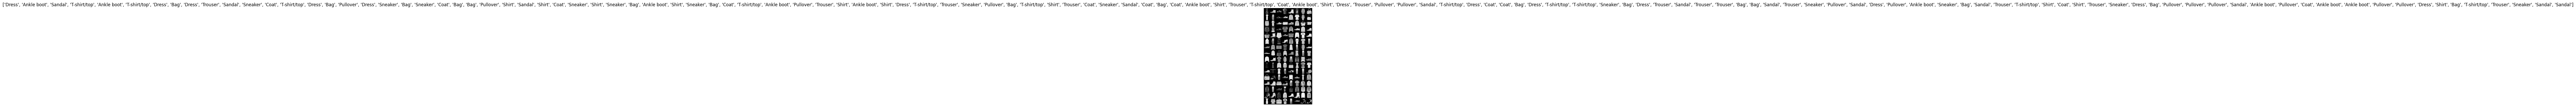

In [6]:
for images, labels in train_loader:
    grid = torchvision.utils.make_grid(images)

    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    # Print out actual labels instead of label indices.
    #plt.title(labels.numpy())  # label indices
    plt.title([train_dataset.classes[label] for label in labels.numpy()])

    plt.axis('off')

    plt.show()

    break

In [7]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [8]:
class DoubleLayerNet(torch.nn.Module):
    def __init__(self, hidden_size1, hidden_size2):
        super(DoubleLayerNet, self).__init__()
        self.hidden1 = torch.nn.Linear(28 * 28, hidden_size1)
        self.relu1 = torch.nn.ReLU()
        self.hidden2 = torch.nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = torch.nn.ReLU()
        self.output = torch.nn.Linear(hidden_size2, 10)

    def forward(self, x):
        out = self.hidden1(x)
        out = self.relu1(out)
        out = self.hidden2(out)
        out = self.relu2(out)
        out = self.output(out)

        return out

In [9]:
n_epochs = 10
learning_rate = 0.0001

model = DoubleLayerNet(128, 128).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
losses = []

model.train()

for epoch in range(n_epochs):
    running_loss = 0

    for images, labels in train_loader:
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    losses.append(running_loss / len(train_loader))

    print(f'Epoch {epoch + 1}/{n_epochs}: {losses[-1]:.4f}')

Epoch 1/10: 141.3785
Epoch 2/10: 75.9242
Epoch 3/10: 65.6654
Epoch 4/10: 60.9048
Epoch 5/10: 57.8427
Epoch 6/10: 55.4871
Epoch 7/10: 53.8335
Epoch 8/10: 52.3219
Epoch 9/10: 51.2638
Epoch 10/10: 50.1460


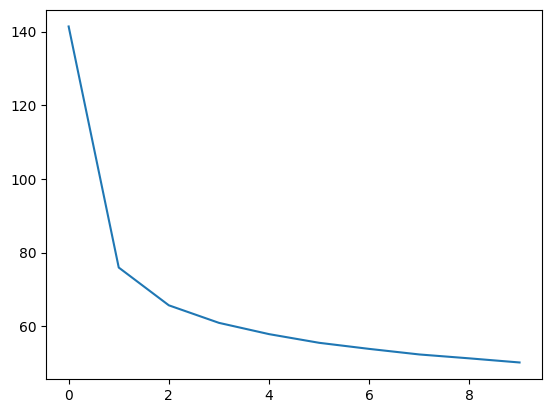

In [11]:
plt.plot(losses)
plt.show()

In [12]:
model.eval()

with torch.no_grad():
    y_true = []
    y_pred = []

    for images, labels in val_loader:
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)

        output = model(images)
        _, preds = torch.max(output.data, 1)

        y_true += list(labels.cpu().numpy())
        y_pred += list(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

              precision    recall  f1-score   support

 T-shirt/top       0.81      0.81      0.81      1000
     Trouser       0.97      0.96      0.97      1000
    Pullover       0.70      0.81      0.75      1000
       Dress       0.82      0.88      0.85      1000
        Coat       0.75      0.75      0.75      1000
      Sandal       0.94      0.93      0.94      1000
       Shirt       0.70      0.53      0.60      1000
     Sneaker       0.91      0.92      0.92      1000
         Bag       0.94      0.95      0.95      1000
  Ankle boot       0.94      0.95      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



convolutional network

In [13]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = torch.nn.Conv2d(1, 16, 3, padding=1)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.pooling1 = torch.nn.MaxPool2d(2)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.pooling2 = torch.nn.MaxPool2d(2)
        self.relu2 = torch.nn.ReLU()

        self.output = torch.nn.Linear(1568, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.pooling1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.pooling2(out)
        out = self.relu2(out)

        out = out.view(out.size(0), -1)
        out = self.output(out)

        return out

In [14]:
n_epochs = 16

model = ConvNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
losses = []

model.train()

for epoch in range(n_epochs):
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)  # no reshaping
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    losses.append(running_loss / len(train_loader))

    print(f'Epoch {epoch + 1}/{n_epochs}: {losses[-1]:.4f}')

Epoch 1/16: 162.4204
Epoch 2/16: 85.3189
Epoch 3/16: 74.7676
Epoch 4/16: 68.0409
Epoch 5/16: 63.2745
Epoch 6/16: 59.9721
Epoch 7/16: 57.3372
Epoch 8/16: 55.3991
Epoch 9/16: 53.6818
Epoch 10/16: 52.3517
Epoch 11/16: 51.1567
Epoch 12/16: 50.1519
Epoch 13/16: 49.4075
Epoch 14/16: 48.4241
Epoch 15/16: 47.6612
Epoch 16/16: 46.9911


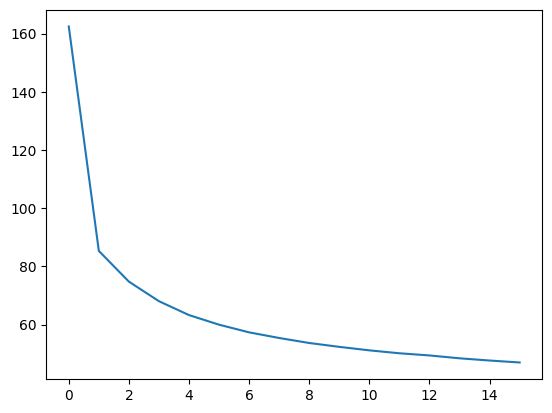

In [16]:
plt.plot(losses)
plt.show()

In [17]:
model.eval()

with torch.no_grad():
    y_true = []
    y_pred = []

    for images, labels in val_loader:
        images = images.to(device)  # no reshaping
        labels = labels.to(device)

        output = model(images)
        _, preds = torch.max(output.data, 1)

        y_true += list(labels.cpu().numpy())
        y_pred += list(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

              precision    recall  f1-score   support

 T-shirt/top       0.78      0.87      0.82      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.78      0.79      0.78      1000
       Dress       0.87      0.88      0.87      1000
        Coat       0.76      0.77      0.76      1000
      Sandal       0.97      0.95      0.96      1000
       Shirt       0.66      0.56      0.61      1000
     Sneaker       0.92      0.94      0.93      1000
         Bag       0.95      0.97      0.96      1000
  Ankle boot       0.95      0.96      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



residual network

In [18]:
class BasicBlock(torch.nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(inplanes, planes, kernel_size=3,
                                    stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.relu = torch.nn.ReLU(inplace=True)

        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3,
                                     stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [19]:
class Bottleneck(torch.nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = torch.nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)

        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                                     padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)

        self.conv3 = torch.nn.Conv2d(planes, planes*4, kernel_size=1, bias=False)
        self.bn3 = torch.nn.BatchNorm2d(planes*4)

        self.relu = torch.nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [20]:
class ResNet(torch.nn.Module):
    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1,
                                     bias=False)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)

        self.avgpool = torch.nn.AvgPool2d(7)
        self.fc = torch.nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, torch.nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = torch.nn.Sequential(
                torch.nn.Conv2d(self.inplanes, planes * block.expansion,
                                kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(planes*block.expansion)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [21]:
n_epochs = 10

model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)  # resnet 18
#model = ResNet(BasicBlock, [3, 4, 6, 3]).to(device)  # resnet 34
#model = ResNet(Bottleneck, [3, 4, 6, 3]).to(device)  # resnet 50
#model = ResNet(Bottleneck, [3, 4, 23, 3]).to(device)  # resnet 101
#model = ResNet(Bottleneck, [3, 8, 26, 3]).to(device)  # resnet 152

#model = torchvision.models.resnet18(pretrained=False)  # pre-implemented from torchvision

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
losses = []

model.train()

for epoch in range(n_epochs):
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)  # no reshaping
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    losses.append(running_loss / len(train_loader))

    print(f'Epoch {epoch + 1}/{n_epochs}: {losses[-1]:.4f}')

Epoch 1/10: 69.7375
Epoch 2/10: 36.6878
Epoch 3/10: 28.9052
Epoch 4/10: 22.8637
Epoch 5/10: 17.5047
Epoch 6/10: 12.6668
Epoch 7/10: 8.9012
Epoch 8/10: 6.3911
Epoch 9/10: 4.6407
Epoch 10/10: 3.4053


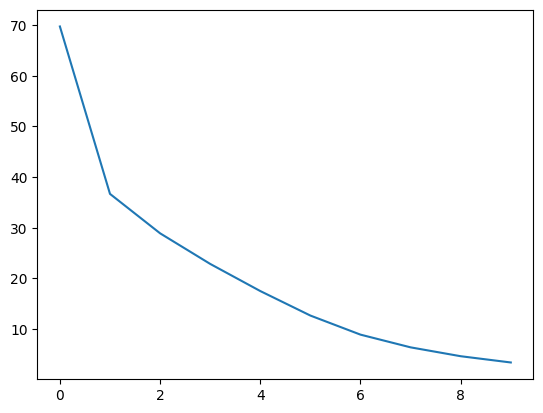

In [23]:
plt.plot(losses)
plt.show()

In [24]:
model.eval()

with torch.no_grad():
    y_true = []
    y_pred = []

    for images, labels in val_loader:
        images = images.to(device)  # no reshaping
        labels = labels.to(device)

        output = model(images)
        _, preds = torch.max(output.data, 1)

        y_true += list(labels.cpu().numpy())
        y_pred += list(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

              precision    recall  f1-score   support

 T-shirt/top       0.79      0.90      0.84      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.78      0.90      0.84      1000
       Dress       0.93      0.89      0.91      1000
        Coat       0.82      0.89      0.85      1000
      Sandal       0.99      0.96      0.98      1000
       Shirt       0.86      0.58      0.69      1000
     Sneaker       0.95      0.98      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.96      0.97      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000

